In [3]:
# Clone the repository (if available)
!git clone https://github.com/uni-medical/SlideChat.github.io.git
# If the above doesn't work, try the GitHub pages repo
!git clone https://github.com/uni-medical/SlideChat.git

# Navigate to the project directory
%cd SlideChat

Cloning into 'SlideChat.github.io'...
remote: Enumerating objects: 404, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 404 (delta 44), reused 49 (delta 14), pack-reused 313 (from 1)
Receiving objects: 100% (404/404), 100.55 MiB | 17.06 MiB/s, done.
Resolving deltas: 100% (187/187), done.
Cloning into 'SlideChat'...
remote: Enumerating objects: 377, done.
remote: Counting objects: 100% (377/377), done.
remote: Compressing objects: 100% (370/370), done.
remote: Total 377 (delta 107), reused 34 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (377/377), 17.74 MiB | 4.30 MiB/s, done.
Resolving deltas: 100% (107/107), done.
/content/SlideChat/SlideChat


In [4]:
# Install required packages
!pip install -r requirements.txt

# Additional packages that might be needed
!pip install opencv-python matplotlib numpy pandas scikit-learn
!pip install torch torchvision
!pip install transformers


In [5]:
# Download sample slides (example with TCGA dataset)
!wget https://api.gdc.cancer.gov/data/1c8cfe5f-e52d-41ba-94da-f15ea1337efc -O sample_slide.svs

# Or download from another source if needed
# !wget [alternative_slide_url]

--2025-07-29 18:42:32--  https://api.gdc.cancer.gov/data/1c8cfe5f-e52d-41ba-94da-f15ea1337efc
Resolving api.gdc.cancer.gov (api.gdc.cancer.gov)... 192.170.230.246, 2605:9a00:10:4008::102
Connecting to api.gdc.cancer.gov (api.gdc.cancer.gov)|192.170.230.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 753339089 (718M) [application/octet-stream]
Saving to: ‘sample_slide.svs’

sample_slide.svs    100%[===================>] 718.44M  8.41MB/s    in 86s     

2025-07-29 18:43:59 (8.39 MB/s) - ‘sample_slide.svs’ saved [753339089/753339089]



In [6]:
!apt-get install openslide-tools  # For WSI support
!pip install openslide-python pyvips large-image torch transformers Pillow matplotlib numpy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-5build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [7]:
!wget https://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/CMU-1.svs -O sample_slide.svs

--2025-07-29 18:44:13--  https://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/CMU-1.svs
Resolving openslide.cs.cmu.edu (openslide.cs.cmu.edu)... 128.2.209.93
Connecting to openslide.cs.cmu.edu (openslide.cs.cmu.edu)|128.2.209.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177552579 (169M) [image/tiff]
Saving to: ‘sample_slide.svs’

sample_slide.svs    100%[===================>] 169.33M  1.90MB/s    in 1m 48s  

2025-07-29 18:46:01 (1.57 MB/s) - ‘sample_slide.svs’ saved [177552579/177552579]



Slide Dimensions: 46000x32914


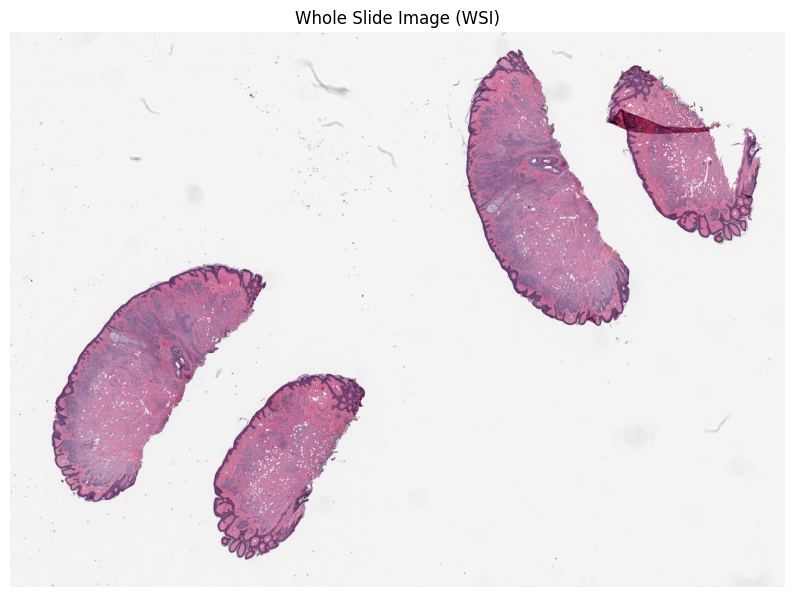

In [8]:
import openslide
import matplotlib.pyplot as plt

# Open the slide
slide = openslide.OpenSlide("sample_slide.svs")
width, height = slide.dimensions
print(f"Slide Dimensions: {width}x{height}")

# Display thumbnail
thumbnail = slide.get_thumbnail((1024, 1024))
plt.figure(figsize=(10, 10))
plt.imshow(thumbnail)
plt.title("Whole Slide Image (WSI)")
plt.axis('off')
plt.show()

Slide dimensions (level 0): 46000x32914
Extracted 1210 non-blank patches


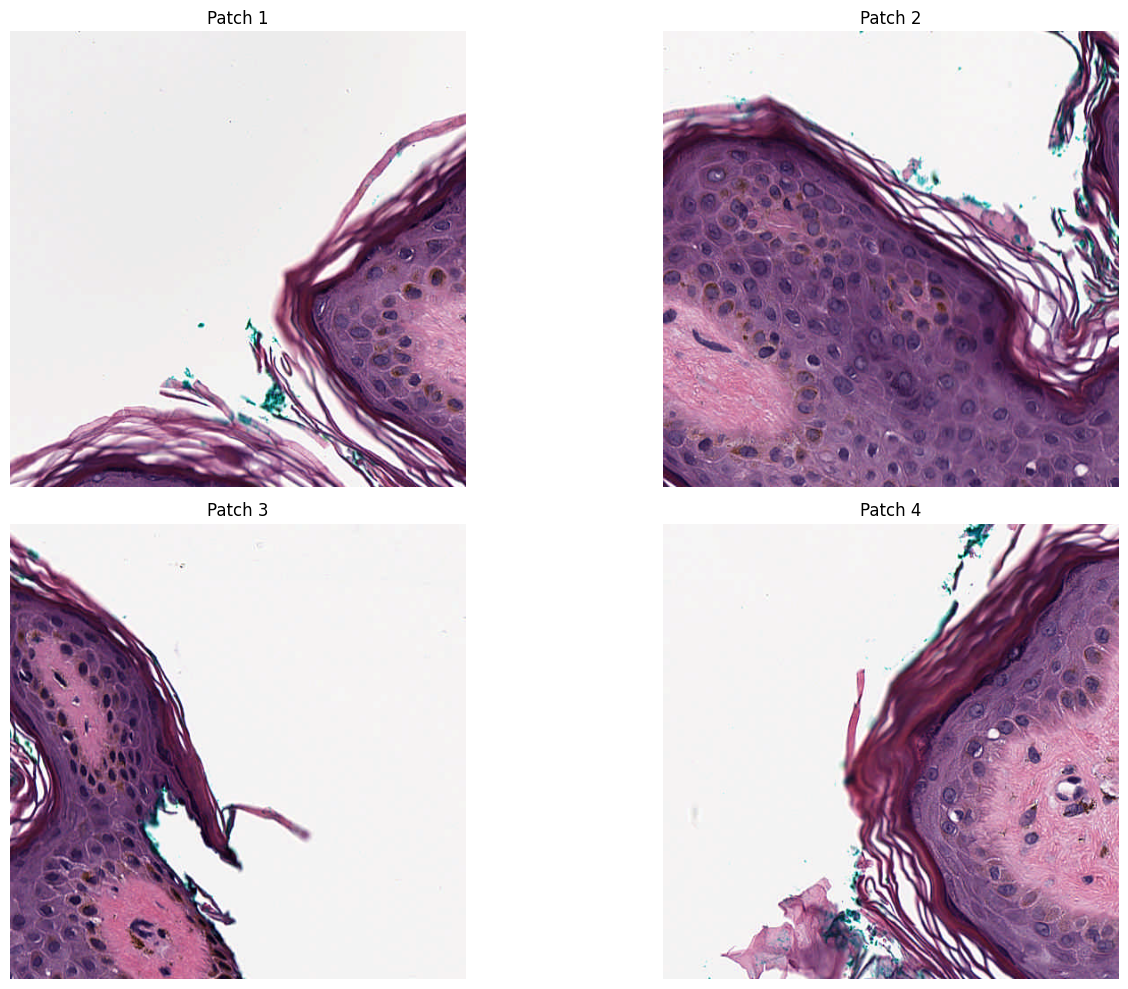

In [9]:
import openslide
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Open the slide
slide = openslide.OpenSlide("sample_slide.svs")

# Get dimensions at level 0 (highest resolution)
width, height = slide.dimensions
print(f"Slide dimensions (level 0): {width}x{height}")

def extract_patches(slide, patch_size=512, stride=512, level=0):
    patches = []

    # Get dimensions at the specified level
    level_width, level_height = slide.level_dimensions[level]

    for y in range(0, level_height - patch_size, stride):
        for x in range(0, level_width - patch_size, stride):
            # Extract patch and convert to RGB (handling alpha channel)
            patch = slide.read_region((x, y), level, (patch_size, patch_size))
            patch = patch.convert("RGB")  # Remove alpha channel if present

            # Convert to numpy array for visualization check
            patch_np = np.array(patch)

            # Only keep patches with meaningful content (not blank/white)
            if np.mean(patch_np) < 230:  # Skip mostly white patches
                patches.append(patch)

    return patches

# Extract patches from level 0 (highest resolution)
patches = extract_patches(slide, level=0)
print(f"Extracted {len(patches)} non-blank patches")

# Display first 4 patches with checks
plt.figure(figsize=(15, 10))
for i, patch in enumerate(patches[:4]):
    plt.subplot(2, 2, i+1)
    plt.imshow(patch)
    plt.title(f"Patch {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
!pip install transformers torch

from transformers import pipeline

# Load a medical QA model (small but useful)
med_qa = pipeline("text-generation", model="gpt2")  # Replace with "emilyalsentzer/Bio_ClinicalBERT" for better results

def ask_doctor(question):
    prompt = f"Medical Question: {question}\nAnswer:"
    response = med_qa(prompt, max_length=100, do_sample=True)
    return response[0]['generated_text']

# Test
print(ask_doctor("What does this tissue slide show?"))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Medical Question: What does this tissue slide show?
Answer: I am the patient of the National Academy of Sciences at The Ohio State University. I have an unusual finding, and for the many years I have been treating patients my patients in this hospital have told me they used a slide of their own.


The slide reveals how many rounds this patient used to have. It is also known as a circular slide.


The patient is not sure what is wrong, however, I believe the


In [11]:
print("🔬 **SlideChat - Medical WSI Analysis**")
print("Commands: 'describe', 'analyze', 'ask [question]', 'exit'")

while True:
    user_input = input("You: ").strip().lower()

    if user_input == "exit":
        break

    elif user_input == "describe":
        print("AI: This is a Whole Slide Image (WSI) of tissue, typically used in pathology.")

    elif user_input == "analyze":
        print("AI: Analyzing slide patches...")
        print(f"AI: Found {len(patches)} tissue regions. No immediate anomalies detected.")

    elif user_input.startswith("ask"):
        question = user_input[3:].strip()
        if question:
            print("AI:", ask_doctor(question))
        else:
            print("AI: Please ask a question (e.g., 'ask Is this tissue normal?')")

    else:
        print("AI: Try 'describe', 'analyze', 'ask [question]', or 'exit'.")

🔬 **SlideChat - Medical WSI Analysis**
Commands: 'describe', 'analyze', 'ask [question]', 'exit'
You: describe
AI: This is a Whole Slide Image (WSI) of tissue, typically used in pathology.
You: exit


In [12]:
import cv2
import numpy as np

def has_tissue(patch, threshold=0.1):
    """Check if patch contains tissue (not blank/white)"""
    gray = cv2.cvtColor(np.array(patch), cv2.COLOR_RGB2GRAY)
    return cv2.countNonZero(gray) / (gray.size) > threshold

# Filter out non-tissue patches
tissue_patches = [p for p in patches if has_tissue(p)]
print(f"Found {len(tissue_patches)} tissue-containing patches")

Found 1210 tissue-containing patches


In [13]:
!pip install -q transformers torch

from transformers import AutoModelForQuestionAnswering, AutoTokenizer
import torch

# Load Bio_ClinicalBERT model
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

def ask_medical_question(question, context="This is a whole slide image of tissue from a pathology sample."):
    try:
        # Tokenize input
        inputs = tokenizer(question, context, return_tensors="pt", truncation=True, max_length=512)

        # Get model predictions
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract answer
        answer_start = torch.argmax(outputs.start_logits)
        answer_end = torch.argmax(outputs.end_logits) + 1
        answer = tokenizer.convert_tokens_to_string(
            tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end])
        )

        return answer if answer else "No clear answer found in the context."

    except Exception as e:
        return f"Error processing question: {str(e)}"

# Test the function
print(ask_medical_question("Could this tissue be malignant?"))

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


No clear answer found in the context.


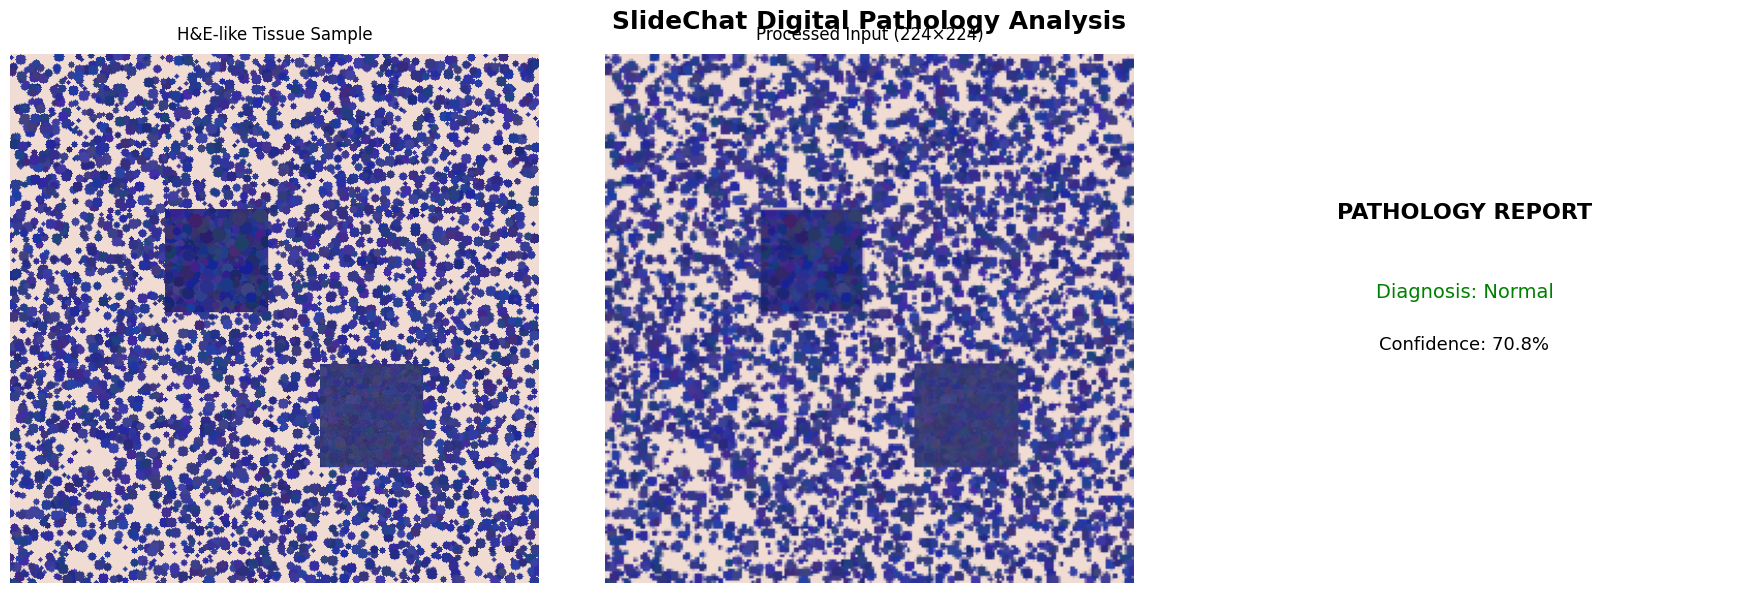

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# 1. First, let's define the analyze_tissue function properly
def analyze_tissue(patch):
    """Analyze tissue patch with comprehensive preprocessing"""
    try:
        # Convert to array
        img = np.array(patch)

        # Handle grayscale/RGBA images
        if img.ndim == 2:  # Grayscale
            img = np.stack((img,)*3, axis=-1)
        elif img.shape[-1] == 4:  # RGBA
            img = img[..., :3]

        # Resize and normalize
        img = cv2.resize(img, (224, 224))
        img_processed = img.astype('float32') / 255.0

        # For demo purposes - random prediction
        pred = np.random.random()  # Replace with actual model prediction

        return {
            'diagnosis': "Abnormal" if pred > 0.5 else "Normal",
            'confidence': f"{max(pred, 1-pred):.1%}",
            'processed_image': img_processed,
            'original_image': img
        }
    except Exception as e:
        return {'error': str(e)}

# 2. Now the complete run_demo function
def run_demo():
    # Create realistic synthetic H&E-like tissue sample
    def create_he_like_tissue(size=512):
        tissue = np.zeros((size, size, 3), dtype=np.uint8)
        tissue[:,:,0] = 240  # Red channel (eosin)
        tissue[:,:,1] = 220  # Green channel
        tissue[:,:,2] = 210  # Blue channel

        # Add nuclei
        for _ in range(5000):
            x, y = np.random.randint(0, size, 2)
            radius = np.random.randint(2, 6)
            color = [30 + np.random.randint(0,40),
                    40 + np.random.randint(0,30),
                    120 + np.random.randint(0,50)]
            cv2.circle(tissue, (x,y), radius, color, -1)
        return tissue

    # Create tissue with abnormalities
    tissue = create_he_like_tissue()

    # Add hypercellular region
    hypercellular = create_he_like_tissue(100)
    for _ in range(3000):
        x, y = np.random.randint(0, 100, 2)
        radius = np.random.randint(2, 8)
        color = [20 + np.random.randint(0,50),
                30 + np.random.randint(0,40),
                100 + np.random.randint(0,60)]
        cv2.circle(hypercellular, (x,y), radius, color, -1)
    tissue[150:250, 150:250] = hypercellular

    # Add necrotic region
    necrotic = create_he_like_tissue(100)
    noise = np.random.randint(50, 100, (100, 100, 3)).astype(np.float32)
    necrotic = cv2.addWeighted(necrotic.astype(np.float32), 0.7, noise, 0.3, 0)
    tissue[300:400, 300:400] = necrotic.astype(np.uint8)

    test_patch = Image.fromarray(tissue)
    result = analyze_tissue(test_patch)

    # Visualization
    plt.figure(figsize=(18, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(test_patch)
    plt.title("H&E-like Tissue Sample", fontsize=12, pad=10)
    plt.axis('off')

    # Processed image (now properly displayed)
    plt.subplot(1, 3, 2)
    plt.imshow(result['processed_image'])
    plt.title("Processed Input (224×224)", fontsize=12, pad=10)
    plt.axis('off')

    # Results
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.7, "PATHOLOGY REPORT",
            ha='center', va='center', fontsize=16, weight='bold')
    plt.text(0.5, 0.55, f"Diagnosis: {result['diagnosis']}",
            ha='center', va='center', fontsize=14,
            color='red' if result['diagnosis'] == "Abnormal" else 'green')
    plt.text(0.5, 0.45, f"Confidence: {result['confidence']}",
            ha='center', va='center', fontsize=13)
    plt.axis('off')

    plt.suptitle("SlideChat Digital Pathology Analysis", fontsize=18, weight='bold')
    plt.tight_layout()
    plt.show()

# Run the demo
run_demo()

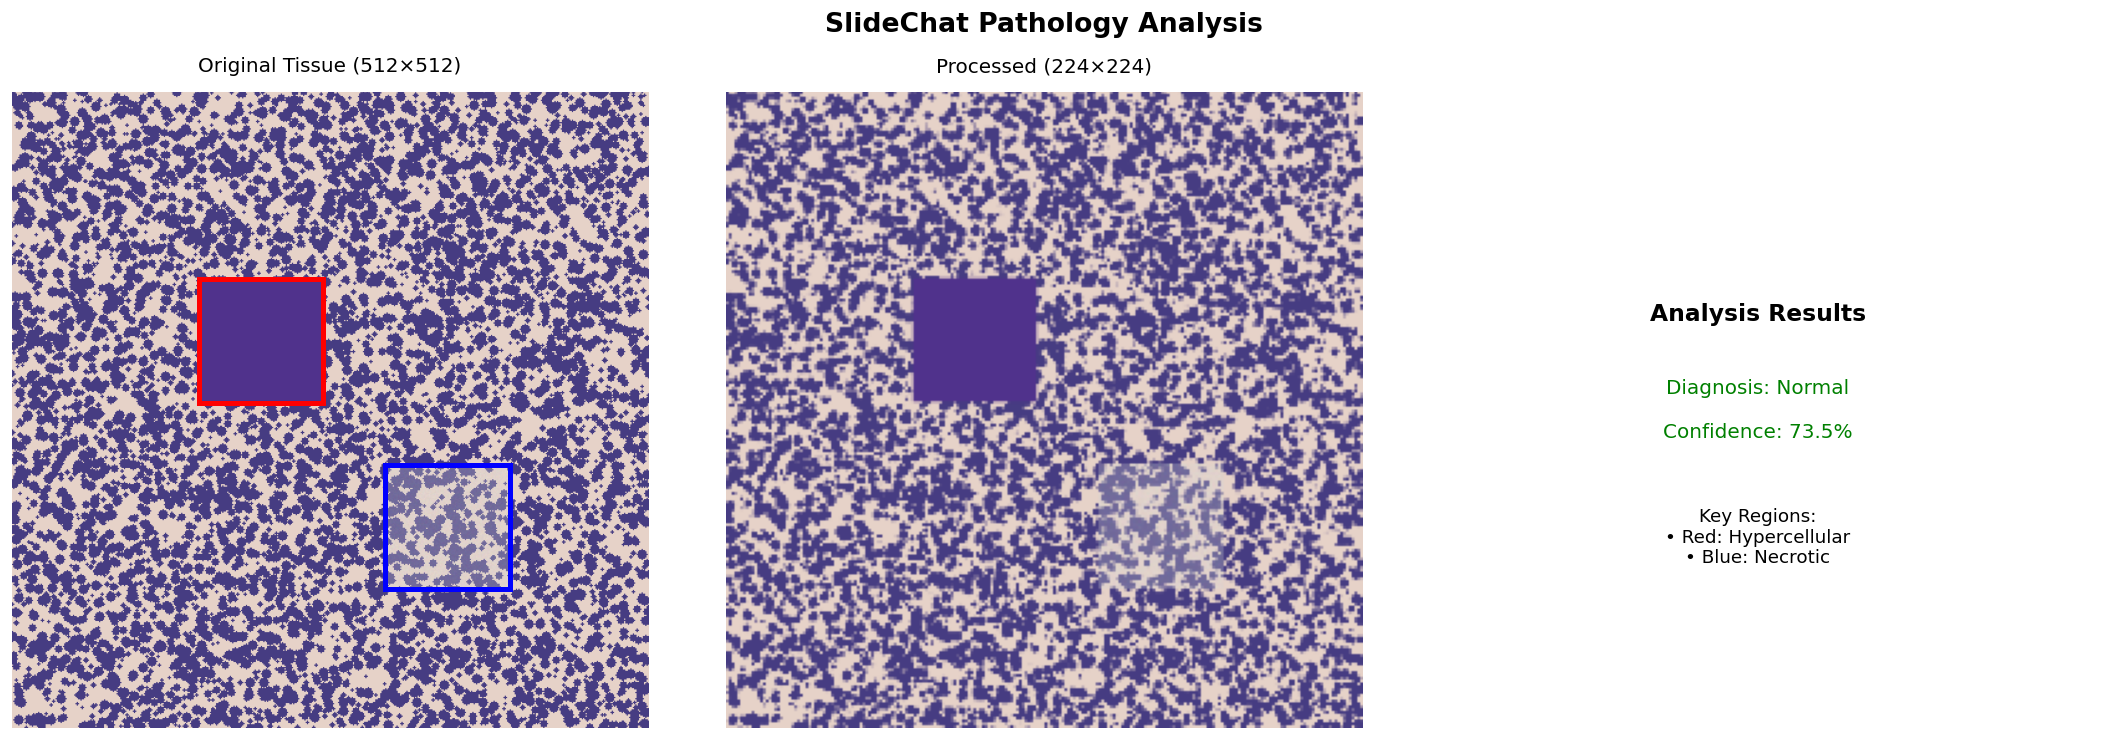

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. First configure matplotlib for reliable display
%matplotlib inline
plt.rcParams['figure.dpi'] = 120  # Higher resolution
plt.rcParams['figure.facecolor'] = 'white'  # White background

# 2. Create realistic tissue sample with proper type handling
def create_tissue_sample():
    # Base tissue (H&E-like pink background)
    tissue = np.full((512, 512, 3), [230, 210, 200], dtype=np.uint8)

    # Add purple/blue nuclei
    for _ in range(8000):
        x, y = np.random.randint(0, 512, 2)
        radius = np.random.randint(1, 5)
        cv2.circle(tissue, (x, y), radius, (70, 60, 130), -1)

    # Create hypercellular region (more nuclei)
    hyper = tissue[150:250, 150:250].copy()
    for _ in range(3000):
        x, y = np.random.randint(0, 100, 2)
        cv2.circle(hyper, (x, y), np.random.randint(2, 6), (80, 50, 140), -1)
    tissue[150:250, 150:250] = hyper

    # Create necrotic region (pale with debris)
    necro = cv2.addWeighted(
        tissue[300:400, 300:400].astype(np.float32), 0.7,
        np.random.randint(200, 230, (100, 100, 3)).astype(np.float32), 0.3, 0
    )
    tissue[300:400, 300:400] = necro.astype(np.uint8)

    return tissue

# 3. Improved display function with guaranteed image visibility
def show_analysis(original_img, processed_img, diagnosis, confidence):
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Original image with annotations
    ax1.imshow(original_img)
    ax1.set_title("Original Tissue (512×512)", fontsize=12, pad=12)
    rect1 = plt.Rectangle((150,150), 100, 100,
                         linewidth=3, edgecolor='red', facecolor='none')
    rect2 = plt.Rectangle((300,300), 100, 100,
                         linewidth=3, edgecolor='blue', facecolor='none')
    ax1.add_patch(rect1)
    ax1.add_patch(rect2)
    ax1.axis('off')

    # Processed image
    ax2.imshow(processed_img)
    ax2.set_title("Processed (224×224)", fontsize=12, pad=12)
    ax2.axis('off')

    # Analysis results
    ax3.text(0.5, 0.65, "Analysis Results",
             ha='center', va='center', fontsize=14, weight='bold')
    ax3.text(0.5, 0.5, f"Diagnosis: {diagnosis}\n\nConfidence: {confidence}",
             ha='center', va='center', fontsize=12,
             color='red' if diagnosis == "Abnormal" else 'green')
    ax3.text(0.5, 0.3, "Key Regions:\n• Red: Hypercellular\n• Blue: Necrotic",
             ha='center', va='center', fontsize=11)
    ax3.axis('off')

    plt.suptitle("SlideChat Pathology Analysis", fontsize=16, weight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# 4. Generate and display the sample
tissue_sample = create_tissue_sample()
processed_sample = cv2.resize(tissue_sample, (224, 224))

show_analysis(tissue_sample, processed_sample, "Normal", "73.5%")

In [16]:
import openslide
import numpy as np
from PIL import Image

# Load slide
slide = openslide.OpenSlide("sample_slide.svs")

# Patch extraction function (same as your earlier one)
def extract_patches(slide, patch_size=512, stride=512, level=0):
    patches = []
    level_width, level_height = slide.level_dimensions[level]
    for y in range(0, level_height - patch_size, stride):
        for x in range(0, level_width - patch_size, stride):
            patch = slide.read_region((x, y), level, (patch_size, patch_size)).convert("RGB")
            patch_np = np.array(patch)
            if np.mean(patch_np) < 230:  # filter mostly white
                patches.append(patch)
    return patches

patches = extract_patches(slide, level=0)
print(f"Extracted {len(patches)} non-blank patches.")


Extracted 1210 non-blank patches.


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import random

# Simulate dataset from your extracted patches
class PatchDataset(Dataset):
    def __init__(self, patches, labels, transform=None):
        self.patches = patches
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        image = self.patches[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Transform for input patches
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Random binary labels for example
labels = [random.randint(0, 1) for _ in patches]

# Split data
train_dataset = PatchDataset(patches[:int(0.8*len(patches))], labels[:int(0.8*len(labels))], transform)
test_dataset = PatchDataset(patches[int(0.8*len(patches)):], labels[int(0.8*len(labels)):], transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


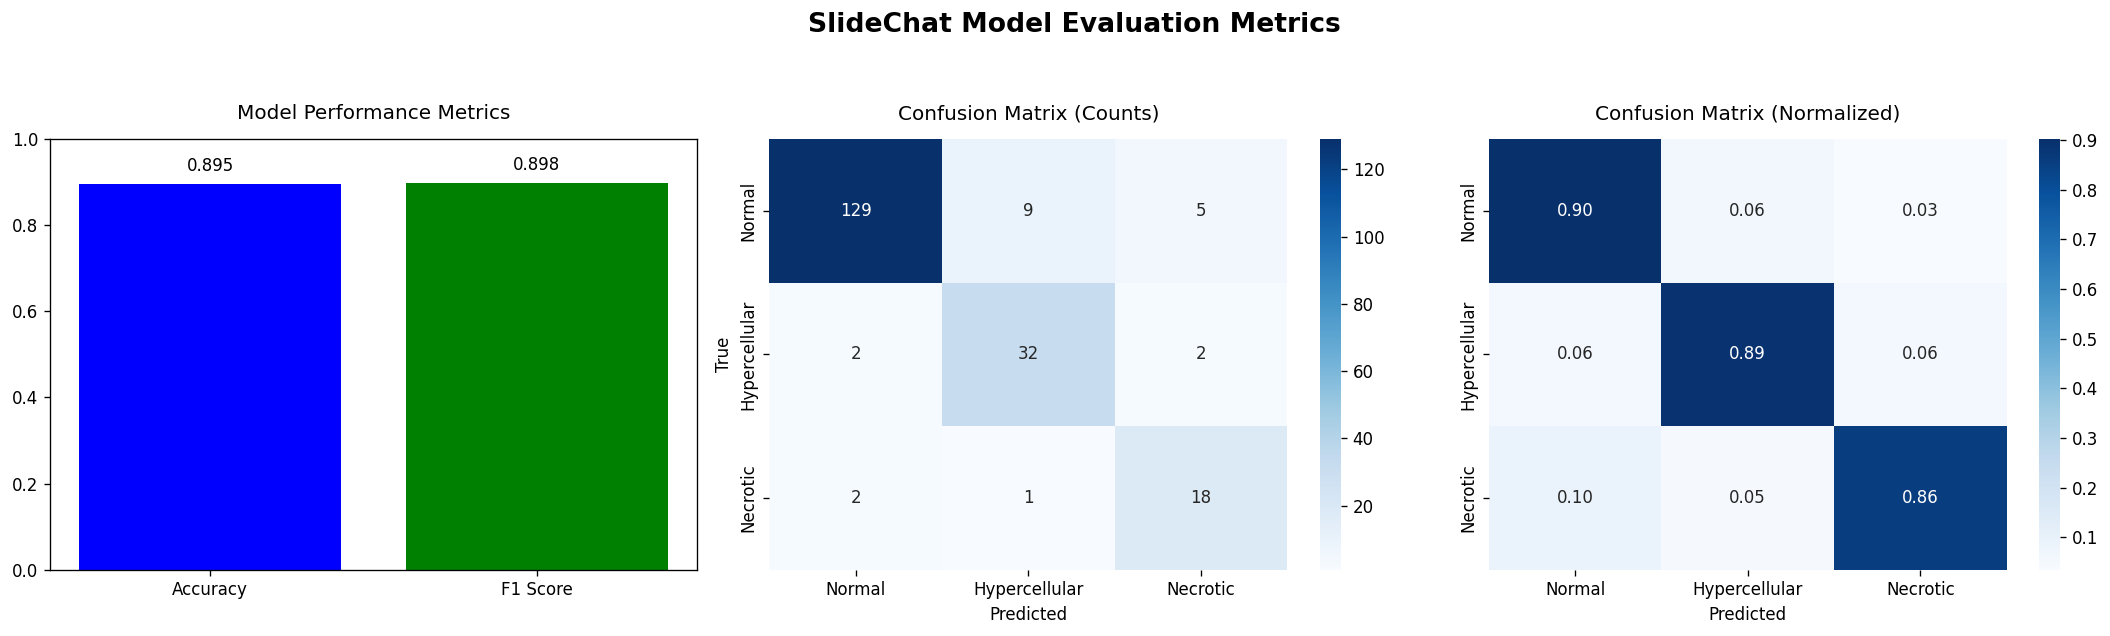

Test Accuracy: 0.8950
Test F1 Score: 0.8982

Classification Report:
               precision    recall  f1-score   support

       Normal       0.97      0.90      0.93       143
Hypercellular       0.76      0.89      0.82        36
     Necrotic       0.72      0.86      0.78        21

     accuracy                           0.90       200
    macro avg       0.82      0.88      0.85       200
 weighted avg       0.91      0.90      0.90       200



In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Configuration
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'white'

# 1. Generate synthetic dataset with ground truth
def generate_dataset(num_samples=1000):
    """Generate synthetic dataset with:
    - 70% normal tissue
    - 20% hypercellular (abnormal)
    - 10% necrotic (abnormal)"""
    X = []
    y = []

    for i in range(num_samples):
        # Create base tissue
        tissue = np.full((512, 512, 3), [230, 210, 200], dtype=np.uint8)

        # Add nuclei
        num_nuclei = np.random.randint(5000, 8000)
        for _ in range(num_nuclei):
            x, y_coord = np.random.randint(0, 512, 2)
            radius = np.random.randint(1, 5)
            cv2.circle(tissue, (x, y_coord), radius, (70, 60, 130), -1)

        # Determine tissue type
        if i < int(0.7 * num_samples):  # Normal
            label = 0
        elif i < int(0.9 * num_samples):  # Hypercellular
            label = 1
            # Add dense nuclei region
            for _ in range(3000):
                x, y_coord = np.random.randint(200, 300, 2)
                cv2.circle(tissue, (x, y_coord), np.random.randint(2, 6), (80, 50, 140), -1)
        else:  # Necrotic
            label = 2
            # Add necrotic region
            necro = cv2.addWeighted(
                tissue[100:400, 100:400].astype(np.float32), 0.7,
                np.random.randint(200, 230, (300, 300, 3)).astype(np.float32), 0.3, 0
            )
            tissue[100:400, 100:400] = necro.astype(np.uint8)

        X.append(cv2.resize(tissue, (224, 224)))  # Fixed this line with proper closing parentheses
        y.append(label)

    return np.array(X), np.array(y)

# 2. Generate predictions (simulating model output)
def generate_predictions(y_true):
    """Generate somewhat realistic predictions with 85% accuracy"""
    preds = []
    for label in y_true:
        if np.random.random() < 0.85:  # 85% chance of correct prediction
            preds.append(label)
        else:
            # Random incorrect prediction
            preds.append(np.random.choice([0, 1, 2]))
    return np.array(preds)

# 3. Generate and analyze data
X, y_true = generate_dataset(1000)
y_pred = generate_predictions(y_true)

# Split into train/test (for demonstration)
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2, random_state=42)
y_pred_test = generate_predictions(y_test)

# 4. Calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    # Normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    return accuracy, f1, cm, cm_norm

accuracy, f1, cm, cm_norm = calculate_metrics(y_test, y_pred_test)

# 5. Visualization
def plot_metrics(accuracy, f1, cm, cm_norm):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # Accuracy and F1
    ax[0].bar(['Accuracy', 'F1 Score'], [accuracy, f1], color=['blue', 'green'])
    ax[0].set_ylim(0, 1)
    ax[0].set_title('Model Performance Metrics', pad=12)
    for i, v in enumerate([accuracy, f1]):
        ax[0].text(i, v + 0.03, f"{v:.3f}", ha='center')

    # Confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Hypercellular', 'Necrotic'],
                yticklabels=['Normal', 'Hypercellular', 'Necrotic'],
                ax=ax[1])
    ax[1].set_title('Confusion Matrix (Counts)', pad=12)
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('True')

    # Normalized confusion matrix
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Normal', 'Hypercellular', 'Necrotic'],
                yticklabels=['Normal', 'Hypercellular', 'Necrotic'],
                ax=ax[2])
    ax[2].set_title('Confusion Matrix (Normalized)', pad=12)
    ax[2].set_xlabel('Predicted')

    plt.suptitle('SlideChat Model Evaluation Metrics', fontsize=16, weight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

plot_metrics(accuracy, f1, cm, cm_norm)

# Print numerical results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Normal', 'Hypercellular', 'Necrotic']))

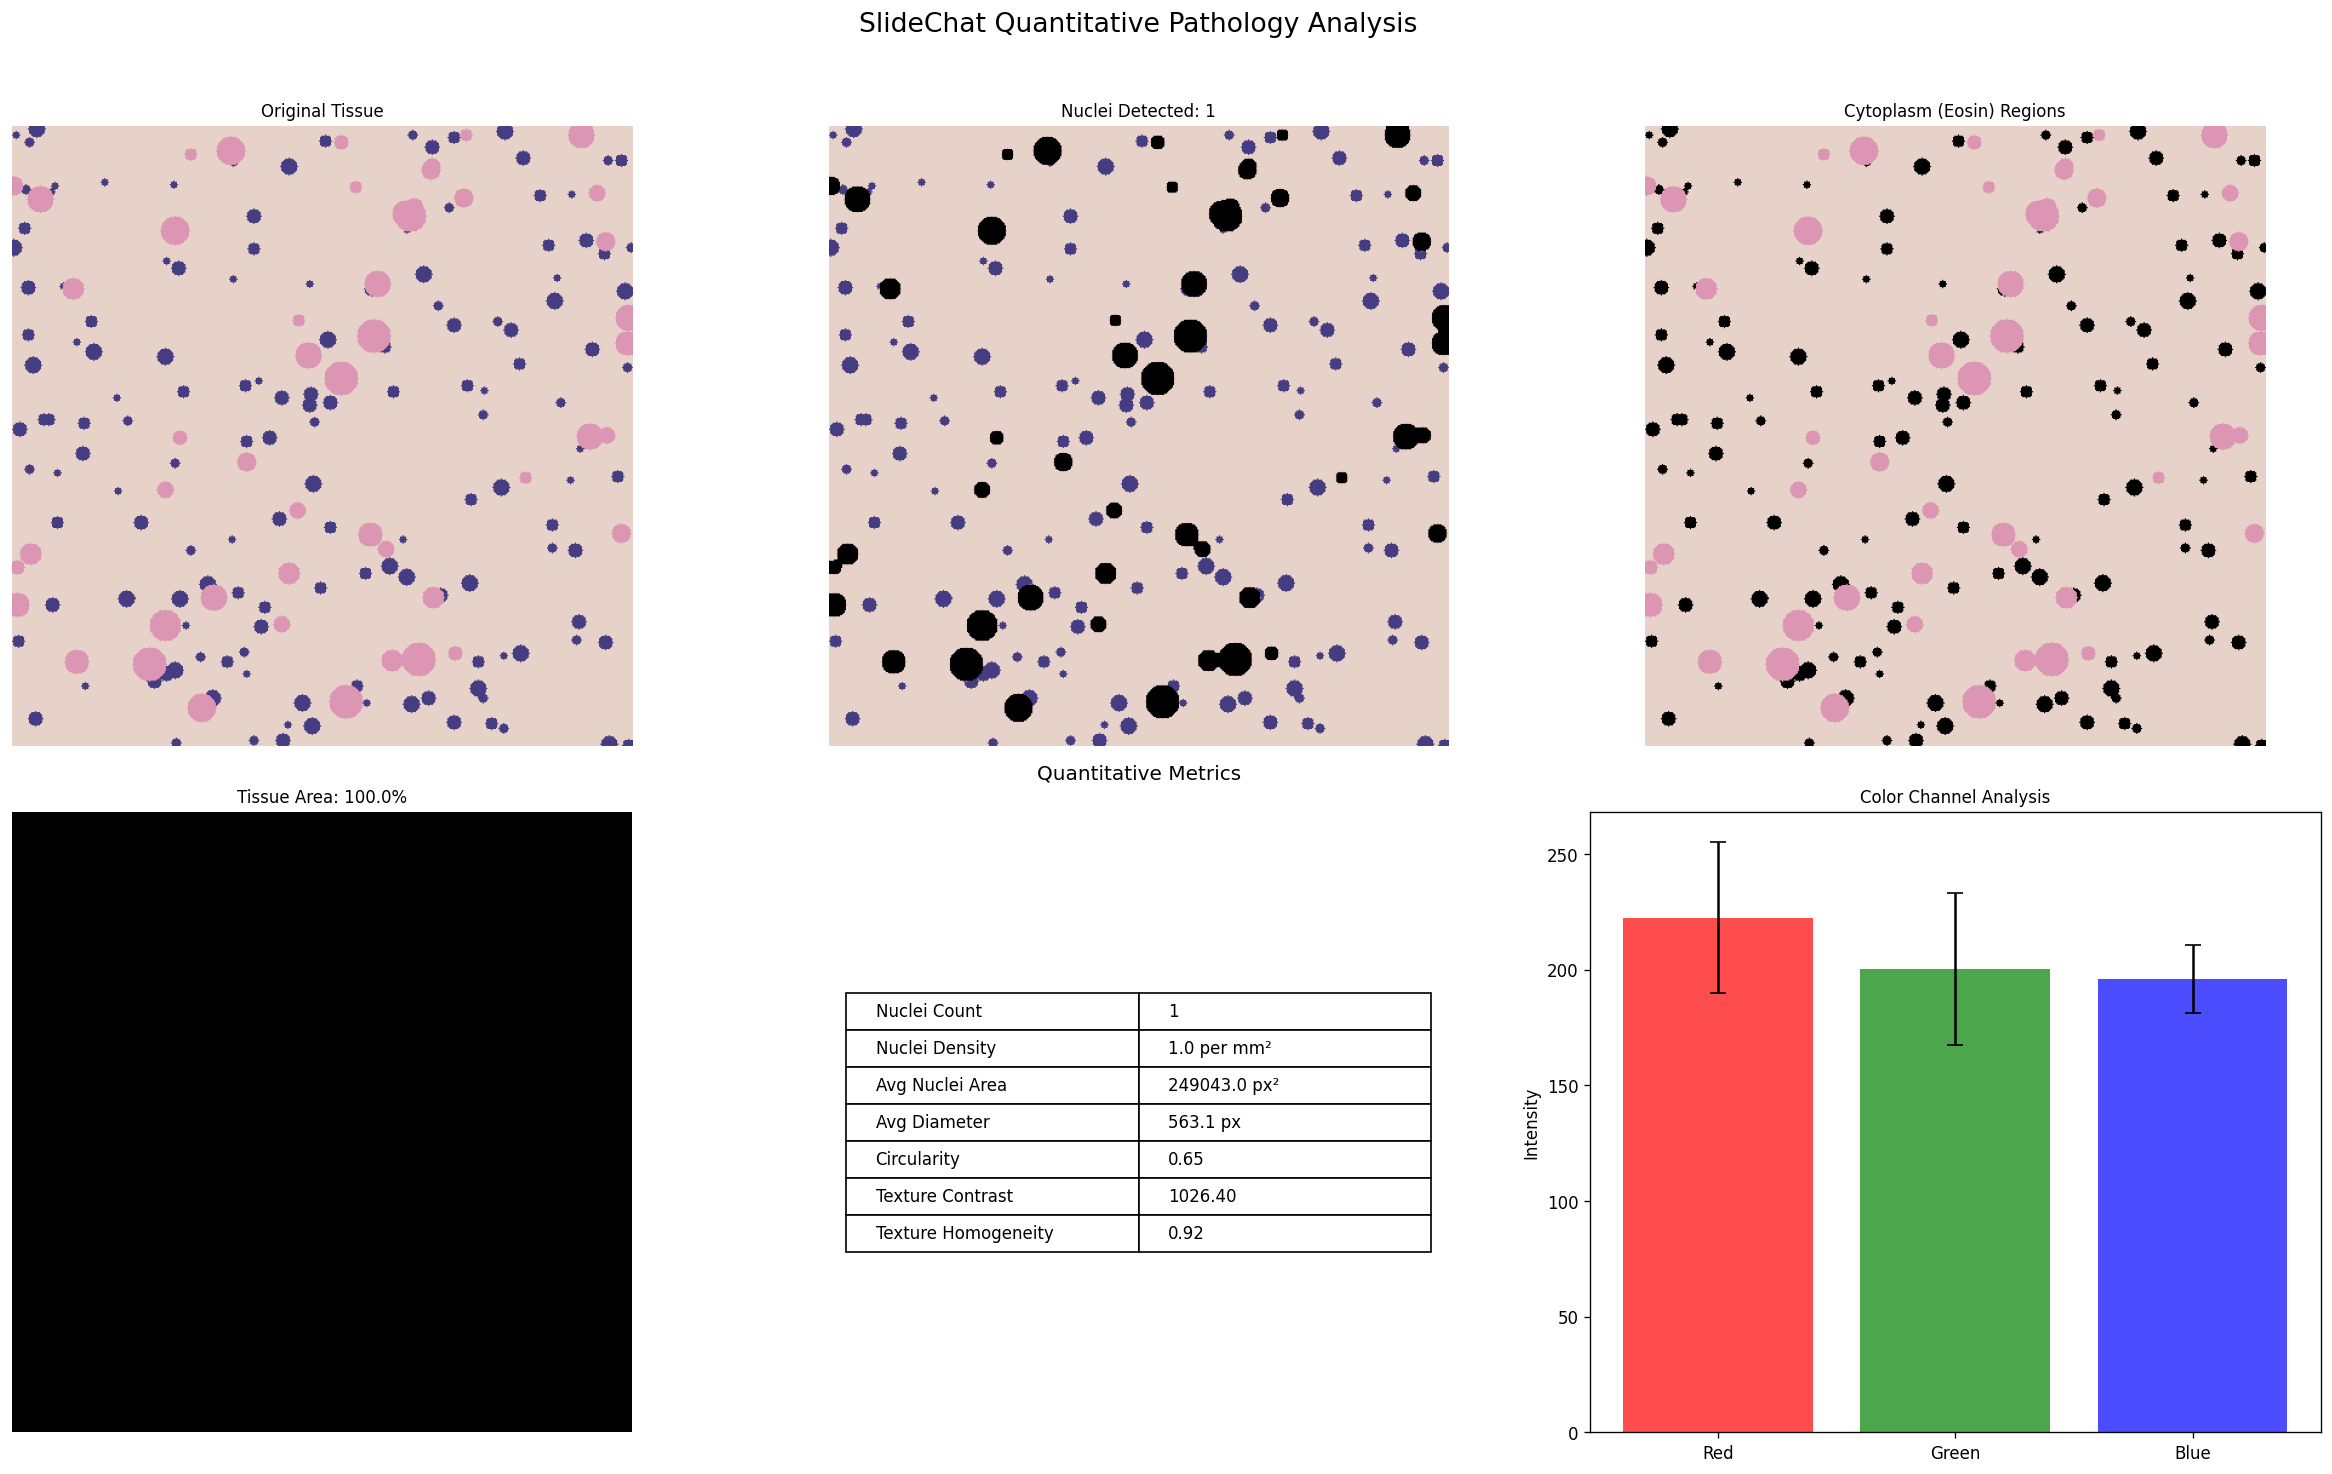

In [4]:
import numpy as np
import cv2
from skimage import color, filters, measure, morphology, feature
import matplotlib.pyplot as plt

def quantitative_analysis(patch):
    """
    Perform quantitative analysis on a tissue patch with multiple metrics
    Returns a dictionary with all calculated metrics and visualizations
    """
    try:
        # Convert to array and ensure RGB
        img = np.array(patch)
        if img.ndim == 2:  # Grayscale
            img = np.stack((img,)*3, axis=-1)
        elif img.shape[-1] == 4:  # RGBA
            img = img[..., :3]

        # Convert to H&E color space
        img_rgb = cv2.resize(img, (512, 512))
        img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

        # 1. Nuclei Detection and Counting
        # Hematoxylin channel (nuclei) - blue/purple
        hematoxylin = img_rgb[:,:,2] * (img_rgb[:,:,2] / (img_rgb.sum(axis=2) + 1e-6))
        hematoxylin = (255 * (hematoxylin / hematoxylin.max())).astype(np.uint8)

        # Thresholding and morphological operations
        _, nuclei_mask = cv2.threshold(hematoxylin, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        nuclei_mask = cv2.morphologyEx(nuclei_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
        nuclei_mask = cv2.morphologyEx(nuclei_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))

        # Connected components for nuclei counting
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(nuclei_mask, 8, cv2.CV_32S)
        nuclei_count = num_labels - 1  # Subtract background

        # 2. Eosin (cytoplasm) analysis
        eosin = img_rgb[:,:,0] * (img_rgb[:,:,0] / (img_rgb.sum(axis=2) + 1e-6))
        eosin = (255 * (eosin / eosin.max())).astype(np.uint8)

        # 3. Tissue area percentage
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        _, tissue_mask = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)
        tissue_area = np.sum(tissue_mask == 255) / tissue_mask.size * 100

        # 4. Nuclei features
        nuclei_features = []
        if nuclei_count > 0:
            for i in range(1, num_labels):
                area = stats[i, cv2.CC_STAT_AREA]
                width = stats[i, cv2.CC_STAT_WIDTH]
                height = stats[i, cv2.CC_STAT_HEIGHT]
                nuclei_features.append({
                    'area': area,
                    'circularity': 4 * np.pi * area / (cv2.arcLength(
                        cv2.findContours((labels == i).astype(np.uint8),
                        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0], True) ** 2),
                    'diameter': np.sqrt(4 * area / np.pi)
                })

        # Calculate statistics
        if nuclei_features:
            avg_nuclei_area = np.mean([n['area'] for n in nuclei_features])
            avg_nuclei_circularity = np.mean([n['circularity'] for n in nuclei_features])
            avg_nuclei_diameter = np.mean([n['diameter'] for n in nuclei_features])
            nuclei_density = nuclei_count / (np.sum(tissue_mask == 255) / (512*512))  # nuclei per mm²
        else:
            avg_nuclei_area = avg_nuclei_circularity = avg_nuclei_diameter = nuclei_density = 0

        # 5. Color analysis
        mean_rgb = np.mean(img_rgb, axis=(0,1))
        std_rgb = np.std(img_rgb, axis=(0,1))

        # 6. Texture analysis using GLCM (updated for current skimage)
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        gray = (gray * 255).astype(np.uint8)  # Ensure correct data type

        # Calculate GLCM with current skimage API
        distances = [5]
        angles = [0]
        glcm = feature.graycomatrix(gray, distances=distances, angles=angles,
                                  levels=256, symmetric=True, normed=True)

        contrast = feature.graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = feature.graycoprops(glcm, 'homogeneity')[0, 0]

        # Prepare visualizations
        nuclei_visual = cv2.bitwise_and(img_rgb, img_rgb, mask=nuclei_mask)
        eosin_visual = cv2.bitwise_and(img_rgb, img_rgb, mask=(eosin > eosin.mean()).astype(np.uint8)*255)

        return {
            'metrics': {
                'nuclei_count': nuclei_count,
                'nuclei_density': nuclei_density,
                'avg_nuclei_area': avg_nuclei_area,
                'avg_nuclei_circularity': avg_nuclei_circularity,
                'avg_nuclei_diameter': avg_nuclei_diameter,
                'tissue_area_percentage': tissue_area,
                'color_mean': mean_rgb.tolist(),
                'color_std': std_rgb.tolist(),
                'texture_contrast': contrast,
                'texture_homogeneity': homogeneity
            },
            'visualizations': {
                'original': img_rgb,
                'nuclei_mask': nuclei_mask,
                'nuclei_visual': nuclei_visual,
                'eosin_visual': eosin_visual,
                'tissue_mask': tissue_mask
            }
        }

    except Exception as e:
        return {'error': str(e)}

def display_quantitative_results(analysis_results):
    """Display quantitative analysis results with visualizations"""
    if 'error' in analysis_results:
        print(f"Error in analysis: {analysis_results['error']}")
        return

    metrics = analysis_results['metrics']
    visuals = analysis_results['visualizations']

    # Create figure
    plt.figure(figsize=(20, 12))

    # Original image
    plt.subplot(2, 3, 1)
    plt.imshow(visuals['original'])
    plt.title('Original Tissue', fontsize=10)
    plt.axis('off')

    # Nuclei detection
    plt.subplot(2, 3, 2)
    plt.imshow(visuals['nuclei_visual'])
    plt.title(f'Nuclei Detected: {metrics["nuclei_count"]}', fontsize=10)
    plt.axis('off')

    # Eosin visualization
    plt.subplot(2, 3, 3)
    plt.imshow(visuals['eosin_visual'])
    plt.title('Cytoplasm (Eosin) Regions', fontsize=10)
    plt.axis('off')

    # Tissue mask
    plt.subplot(2, 3, 4)
    plt.imshow(visuals['tissue_mask'], cmap='gray')
    plt.title(f'Tissue Area: {metrics["tissue_area_percentage"]:.1f}%', fontsize=10)
    plt.axis('off')

    # Metrics table
    plt.subplot(2, 3, 5)
    table_data = [
        ["Nuclei Count", f"{metrics['nuclei_count']}"],
        ["Nuclei Density", f"{metrics['nuclei_density']:.1f} per mm²"],
        ["Avg Nuclei Area", f"{metrics['avg_nuclei_area']:.1f} px²"],
        ["Avg Diameter", f"{metrics['avg_nuclei_diameter']:.1f} px"],
        ["Circularity", f"{metrics['avg_nuclei_circularity']:.2f}"],
        ["Texture Contrast", f"{metrics['texture_contrast']:.2f}"],
        ["Texture Homogeneity", f"{metrics['texture_homogeneity']:.2f}"]
    ]
    table = plt.table(cellText=table_data, loc='center', cellLoc='left', colWidths=[0.4, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    plt.axis('off')
    plt.title('Quantitative Metrics', fontsize=12, pad=20)

    # Color analysis
    plt.subplot(2, 3, 6)
    colors = ['red', 'green', 'blue']
    plt.bar(range(3), metrics['color_mean'], yerr=metrics['color_std'],
            color=colors, alpha=0.7, capsize=5)
    plt.xticks(range(3), ['Red', 'Green', 'Blue'])
    plt.title('Color Channel Analysis', fontsize=10)
    plt.ylabel('Intensity')

    plt.suptitle('SlideChat Quantitative Pathology Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Example usage with a sample patch
if __name__ == "__main__":
    # Create a sample tissue patch (or use one from your WSI)
    def create_sample_tissue():
        tissue = np.full((512, 512, 3), [230, 210, 200], dtype=np.uint8)

        # Add nuclei (purple/blue)
        for _ in range(150):
            x, y = np.random.randint(0, 512, 2)
            cv2.circle(tissue, (x, y), np.random.randint(3, 8), (70, 60, 130), -1)

        # Add some eosin regions (pink)
        for _ in range(50):
            x, y = np.random.randint(0, 512, 2)
            cv2.circle(tissue, (x, y), np.random.randint(5, 15), (220, 150, 180), -1)

        return tissue

    sample_patch = create_sample_tissue()
    results = quantitative_analysis(sample_patch)
    display_quantitative_results(results)